In [163]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder
import matplotlib.pyplot as plt
from odbm.vis import *

In [164]:
model_species = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl')
model_rxns = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Reaction', engine = 'openpyxl')

In [165]:
expression_limit = 0.05 
enzyme_ratio = {'Sda':1, 'PCX': 2, 'Mdh': 3}
N_ratios = sum(enzyme_ratio.values())
expression_fudge = 1/10
enzymeInit = {k:expression_limit*expression_fudge/N_ratios*v for k,v in enzyme_ratio.items()}

solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}
solubilities['Serine'] = min(solubilities.values())

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

# constant_species = ['ATP','NADH']
# # this kind of works
# for s in constant_species:
#     model_species.loc[model_species['Label'] == s,'Label'] = '$'+s

serine_mw = 105.09
malate_mw = 134.0874

In [196]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns[:27])
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
r  = te.loada(model)

sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))[:4]
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))[:4]
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))[:4]

In [197]:
sdaV

['SDA_MSMEG', 'SDA_BSUB', 'SDA_ECOLI', 'SDA_LPNEU']

In [198]:
results_id = np.empty((len(sdaV), len(pcxV), len(mdhV)), dtype=int)
results = []

count = 0
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            r['['+sda+'_DNA]'] = 1#enzymeInit['Sda']
            r['['+pcx+'_DNA]'] = 1#enzymeInit['PCX']
            r['['+mdh+'_DNA]'] = 1#enzymeInit['Mdh']
            results_id[i,j,k] = count
            results.append(r.simulate(0,120000,1000))
            r.reset()
            count += 1

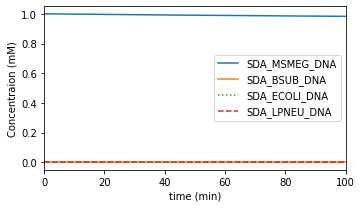

In [204]:
sp = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))[4:]
ls = [None, None, 'dotted','dashed']

species_plot(myModel, results[0], sp, linestyles=ls)

plt.xlim(0, 100)
#plt.ylim(0,200)
plt.legend(sp)

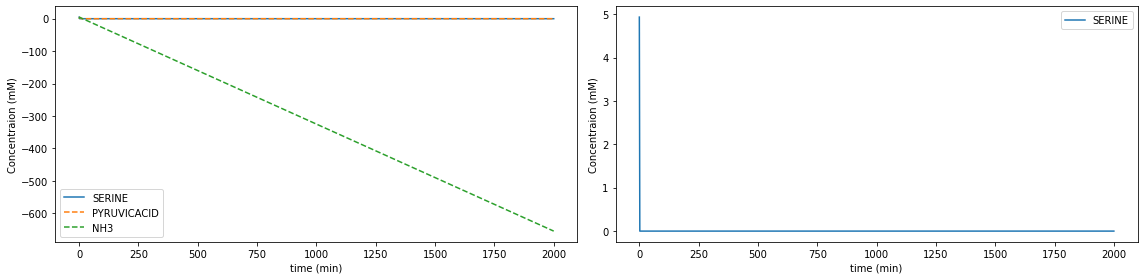

In [201]:
rxn_plot(myModel, results[0], [0,21], figsize=(16,4));

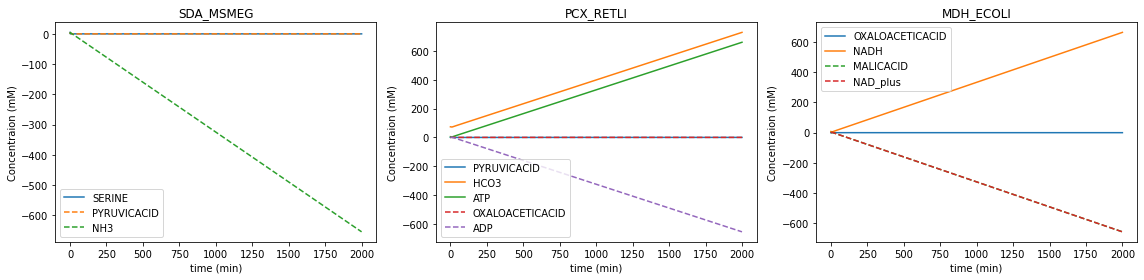

In [202]:
variants = (0,0,0) #define combination of variants to plot
v_labels = [v[k] for v,k in zip([sdaV, pcxV, mdhV], variants)] #get variant names
run = int(results_id[variants]) #return simulation run  # in which that combination was tested
rxn_idx = [int(variants[0]),int(variants[1]+4), int(variants[2]+8)] #brute force method of getting reaction index for each variant
rxn_plot(myModel, results[run], rxn_idx, figsize=(16,4), titles = v_labels);

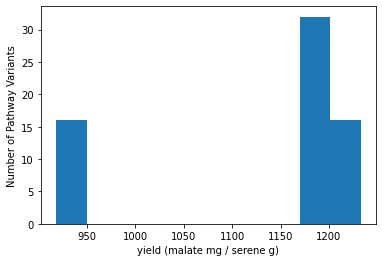

In [149]:
plt.hist([((r['[MALICACID]'][-1]*malate_mw)/(r['[SERINE]'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

In [37]:
#dummy test of different enzyme ratios 
#testing just one combination of enzyme variants

ratios = [1,5,10]
results_id = np.empty((len(ratios), len(ratios), len(ratios)), dtype=int)
results = []
count = 0

for i in ratios:
    for j in ratios:
        for k in ratios:
            r['['+sdaV[0]+']'] = enzymeInit*(i/sum(ratios))
            r['['+pcxV[0]+']'] = enzymeInit*(j/sum(ratios))
            r['['+mdhV[0]+']'] = enzymeInit*(k/sum(ratios))

            #results_id[i-1,j-1,k-1] = count
            results.append(r.simulate(0,1200,1000))
            r.reset()
            count += 1

In [ ]:
'''
species = ['[SERINE]','[PYRUVICACID]','[OXALOACETICACID]', '[MALICACID]']
sample = [0, 5, 10, 15, 20, 25]
for s in sample:
    sim = results[s]
    plt.figure()
    for sp in species:
        plt.plot(sim['time'],sim[sp])
        plt.legend(labels = ['Serine','Pyruvate','Oxaloacetate', 'Malate'])
'''

sample = [0, 5, 10, 15, 20, 25]
for s in sample:
    sim = results[s]
    plt.figure()
    plt.plot(sim['time'],sim['[MALICACID]'])




In [23]:
results[0]['time'][-1]/60

20.0

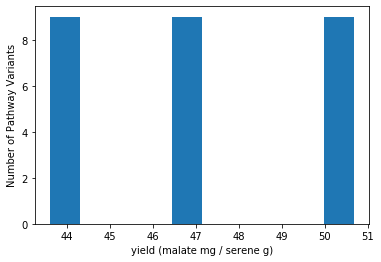

In [39]:
plt.hist([((r['[MALICACID]'][-1]*malate_mw)/(r['[SERINE]'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

In [182]:
myModel.writeParameters(myModel.get_reaction(23))


'Cmax_R24=0.05; \ntau_R24=14400; \n'

In [188]:
myModel.mech_dict['EXP'](myModel.get_reaction(23)).writeRate()

'R24 := Cmax_R24/tau_R24*exp^(-time/tau_R24)*MDH_ECOLI_DNA'

In [190]:
myModel.compile()

'# Initialize concentrations \nSERINE=4.93095; \nHCO3=73.5294; \nPYRUVICACID=0.0; \nOXALOACETICACID=0.0; \nATP=4.93095; \nAMP=0.0; \nADP=0.0; \nNADPH=0.0; \nNADP_plus=0.0; \nNADH=7.536950000000001; \nNAD_plus=0.0; \nSDA_MSMEG=0.0; \nSDA_BSUB=0.0; \nSDA_ECOLI=0.0; \nSDA_LPNEU=0.0; \nPCX_RETLI=0.0; \nPCX_SCER=0.0; \nPCX_MSMEG=0.0; \nPCX_GTHERM=0.0; \nMDH_ECOLI=0.0; \nMDH_MDOM=0.0; \nMDH_REMER=0.0; \nMDH_TAES=0.0; \nSDA_MSMEG_DNA=0.0; \nSDA_BSUB_DNA=0.0; \nSDA_ECOLI_DNA=0.0; \nSDA_LPNEU_DNA=0.0; \nPCX_RETLI_DNA=0.0; \nPCX_SCER_DNA=0.0; \nPCX_MSMEG_DNA=0.0; \nPCX_GTHERM_DNA=0.0; \nMDH_ECOLI_DNA=0.0; \nMDH_MDOM_DNA=0.0; \nMDH_REMER_DNA=0.0; \nMDH_TAES_DNA=0.0; \n\n# Initialize parameters \nkcat_R1=500; \nKm_R1=.00258; \n\nkcat_R2=585; \nKm_R2=29.2; \n\nkcat_R3=436; \nKm_R3=2.67; \n\nkcat_R4=506; \nKm_R4=2.2; \n\nkcat_R5=7.33; \nKm1_R5=1.65; \nKm2_R5=10.8; \nmaxC_R5=4; \n\nkcat_R6=60; \nKm1_R6=.5; \nKm2_R6=1.36; \nmaxC_R6=4; \n\nkcat_R7=33.5; \nKm1_R7=.375; \nKm2_R7=3.8; \nmaxC_R7=4; \n\nkca